In [104]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Suppress some SHAP/XGBoost warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None # default='warn', suppress SettingWithCopyWarning for imputation steps


In [105]:
######################################################################
# PULL BASE XGBOOST MODELS AND DATA NEEDED
######################################################################

# Call Xgboost model with wildfire features
loaded_model_ubj = XGBRegressor()
loaded_model_ubj.load_model('../30_Wildfire_Power_Experiment/xgboost_wf_model.ubj') # or 'xgboost_base_model.ubj'

# Pull required datasets
test_data = pd.read_csv("../30_Wildfire_Power_Experiment/test_data_xgboost.csv")
X_test_wf_processed = pd.read_csv("../30_Wildfire_Power_Experiment/X_test_xgboost.csv")

TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'

In [ ]:
######################################################################
# FAIRNESS AND BIAS BY DEMOGRAPHIC: PERFORMANCE METRICS
######################################################################

# Step 1: Define demographic buckets
demographic_groups = test_data['INCOMExRACE'].unique()

# Step 2: Store results
results_by_demographic = {}

# Step 3: Loop through each demographic group
for group in demographic_groups:
    #print(f"Evaluating group: {group}")

    # Subset the test data
    mask = test_data['INCOMExRACE'] == group
    X_test_subset = X_test_wf_processed.loc[mask]  # preprocessed features (without Demographic_Bucket!)
    y_test_subset = test_data.loc[mask, TARGET_VARIABLE]

    # Check if empty
    if X_test_subset.empty:
        print(f"Warning: No samples found for group '{group}'. Skipping.")
        continue

    # Predict
    y_pred_subset = loaded_model_ubj.predict(X_test_subset)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
    mae = mean_absolute_error(y_test_subset, y_pred_subset)
    r2 = r2_score(y_test_subset, y_pred_subset)

    # Save results
    results_by_demographic[group] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Step 4: Print results nicely

# Step 4: Convert results to DataFrame and display
df_results = pd.DataFrame.from_dict(results_by_demographic, orient='index')
df_results.index.name = 'Demographic Group'
df_results.reset_index(inplace=True)

# Round metrics to 2 decimal points
df_results_rounded = df_results.copy()
df_results_rounded['RMSE'] = df_results_rounded['RMSE'].round(2)
df_results_rounded['MAE'] = df_results_rounded['MAE'].round(2)
df_results_rounded['R2'] = df_results_rounded['R2'].round(2)

print(df_results_rounded)




          Demographic Group  RMSE   MAE    R2
0    High Income White Area  3.01  2.47  0.83
1  Middle Income White Area  3.62  2.86  0.83
2    Middle Income POC Area  2.90  2.32  0.89
3       Low Income POC Area  3.57  2.36  0.94
4      High Income POC Area  2.48  2.10  0.89
5     Low Income White Area  3.02  2.37  0.95



--- Mean Residual by Demographic Group ---
Middle Income White Area: mean residual = -2.6809 → model is overpredicting
High Income White Area: mean residual = -2.2524 → model is overpredicting
Middle Income POC Area: mean residual = -2.1146 → model is overpredicting
Low Income White Area: mean residual = -2.0510 → model is overpredicting
High Income POC Area: mean residual = -1.9440 → model is overpredicting
Low Income POC Area: mean residual = -1.8461 → model is overpredicting


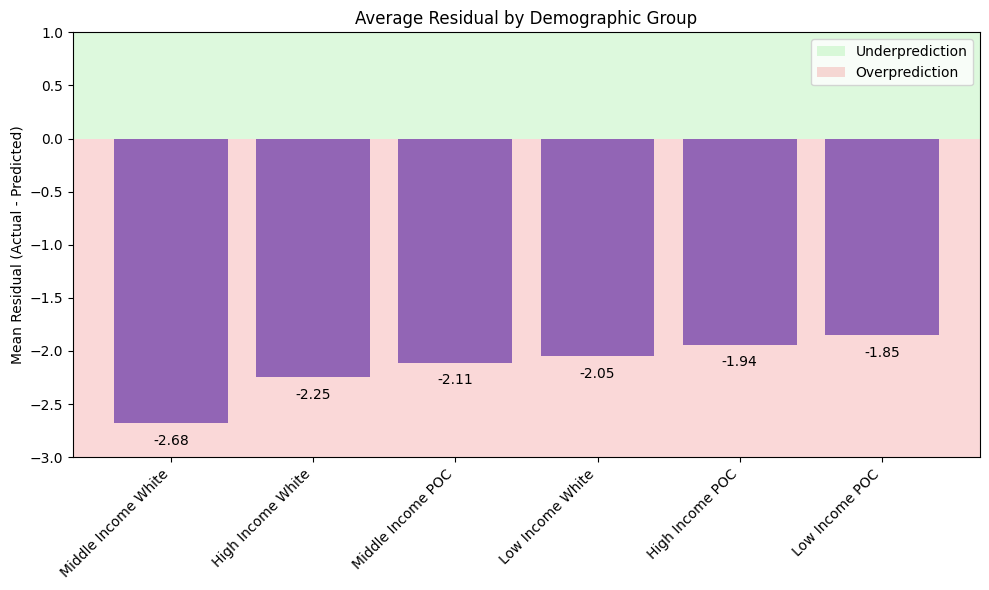

In [107]:
######################################################################
# ANALYZE RESIDUAL BIAS
######################################################################

# Step 4: Calculate residuals
# Make predictions for the full test set
test_data['Prediction'] = loaded_model_ubj.predict(X_test_wf_processed)

test_data['residual'] = test_data[TARGET_VARIABLE] - test_data['Prediction']

# Group by demographic bucket and calculate mean residual
residual_bias_by_group = test_data.groupby('INCOMExRACE')['residual'].mean().sort_values()

# Print it nicely
print("\n--- Mean Residual by Demographic Group ---")
for group, mean_res in residual_bias_by_group.items():
    direction = "underpredicting" if mean_res > 0 else "overpredicting"
    print(f"{group}: mean residual = {mean_res:.4f} → model is {direction}")

# Plot it nicely

# Sample data
data = {
    'Demographic Group': [
        'Middle Income White', 'High Income White', 'Middle Income POC',
        'Low Income White', 'High Income POC', 'Low Income POC'
    ],
    'Mean Residual': [-2.68, -2.25, -2.11, -2.05, -1.94, -1.85]
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df['Demographic Group'], df['Mean Residual'], color='slateblue')

# Add shading for residual direction
ymin, ymax = -3, 1
ax.set_ylim(ymin, ymax)
ax.axhspan(0, ymax, facecolor='lightgreen', alpha=0.3, label='Underprediction')
ax.axhspan(ymin, 0, facecolor='lightcoral', alpha=0.3, label='Overprediction')

# Add labels to bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height - 0.1, f'{height:.2f}',
            ha='center', va='top', fontsize=10)

# Customize labels and legend
ax.set_title('Average Residual by Demographic Group')
ax.set_ylabel('Mean Residual (Actual - Predicted)')
ax.set_xticklabels(df['Demographic Group'], rotation=45, ha='right')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [108]:
######################################################################
# T-TEST TO COMPARE RESIDUAL BIAS ACROSS GROUPS
######################################################################

from scipy.stats import ttest_ind

# Define group comparisons
group_pairs = [
    ("Middle Income White Area", "Low Income POC Area"),
    ("High Income White Area", "High Income POC Area"),
    ("Middle Income White Area", "Middle Income POC Area"),
    ("Low Income POC Area", "High Income POC Area"),
    ("Low Income White Area", "High Income White Area")
]

# Create an empty list to collect results
results = []

# Loop through group pairs
for group_a, group_b in group_pairs:
    res_a = test_data[test_data["INCOMExRACE"] == group_a]["residual"]
    res_b = test_data[test_data["INCOMExRACE"] == group_b]["residual"]
    
    stat, p_value = ttest_ind(res_a, res_b, equal_var=False)
    significance = "Significant" if p_value < 0.05 else "Not Significant"
    
    results.append({
        "Group A": group_a,
        "Group B": group_b,
        "T-statistic": round(stat, 4),
        "P-value": round(p_value, 4),
        "Significance": significance
    })

# Convert to DataFrame
t_test_results_df = pd.DataFrame(results)

# Display the table
t_test_results_df




,Group A,Group B,T-statistic,P-value,Significance
0,Middle Income White Area,Low Income POC Area,-10.5475,0.0000,Significant
1,High Income White Area,High Income POC Area,-2.1607,0.0313,Significant
2,Middle Income White Area,Middle Income POC Area,-12.5817,0.0000,Significant
3,Low Income POC Area,High Income POC Area,0.7317,0.4648,Not Significant
4,Low Income White Area,High Income White Area,1.8204,0.0690,Not Significant
